# Download Training Data

In [1]:
!rm -rf samples

# !wget --no-check-certificate https://muthanna.com/deepears/samples-v3.zip
# !wget --no-check-certificate https://muthanna.com/deepears/sweetchild-8bit.wav
# !wget --no-check-certificate https://muthanna.com/deepears/deepears_chord_model.h5
# !wget --no-check-certificate https://muthanna.com/deepears/deepears_root_model.h5

!wget --no-check-certificate https://muthanna.com/deepears/instrument-samples-v1.zip
!unzip -q instrument-samples-v1.zip
!ls -l samples/ | wc -l
!ls -l samples | head

import os
files = os.listdir("samples")

--2020-03-13 13:26:42--  https://muthanna.com/deepears/instrument-samples-v1.zip
Resolving muthanna.com (muthanna.com)... 35.244.227.152
Connecting to muthanna.com (muthanna.com)|35.244.227.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585407085 (558M) [application/zip]
Saving to: ‘instrument-samples-v1.zip.3’

instrument-samples- 100%[===================>] 558.29M   109MB/s    in 6.0s    

2020-03-13 13:26:48 (93.2 MB/s) - ‘instrument-samples-v1.zip.3’ saved [585407085/585407085]

8998
total 791736
-rw-r--r-- 1 jupyter jupyter 88244 Mar  4 19:45 note-A2-P0-110.000-S0-V0.59-noreject-instrument.wav
-rw-r--r-- 1 jupyter jupyter 88244 Mar  4 19:45 note-A2-P0-152.000-S42-V0.52-noreject-instrument.wav
-rw-r--r-- 1 jupyter jupyter 88244 Mar  4 19:45 note-A2-P0-152.000-S42-V0.5-noreject-instrument.wav
-rw-r--r-- 1 jupyter jupyter 88242 Mar  4 19:45 note-A2-P0-154.000-S44-V0.83-noreject-instrument.wav
-rw-r--r-- 1 jupyter jupyter 88244 Mar  4 19:45 note-A2-P0-16

In [3]:
import os
files = os.listdir("samples")

# Helper methods

In [4]:
%matplotlib inline
from helpers import Config

config = Config(
    rows=129,
    cols = 71,
    s_nperseg = 256,
    s_nfft = 256,
    s_noverlap = 32,
    log_scale = True,
    resample = 16000)

DefaultConfig = config

def spectrogram(xs, mode='complex'):
  return signal.spectrogram(xs, 256, window=('hann'), nperseg=256, nfft=256, mode=mode)

def play_file(file, config=DefaultConfig):
  fs, data = wavfile.read(file)
  if config.resample > 0:
    number_of_samples = round(len(data) * float(config.resample) / fs)
    data = signal.resample(data, number_of_samples)
    fs = config.resample

  display.display(display.Audio(data, rate=fs))

def spectrogram_from_file(file=None, data=None, fs=None, transpose=False, render=True, config=DefaultConfig):
  if data is None:
    fs, data = wavfile.read(file)
    if config.resample > 0:
      number_of_samples = round(len(data) * float(config.resample) / fs)
      data = signal.resample(data, number_of_samples)
      fs = config.resample

  if config.slice_start_s > 0:
    start_sample = config.slice_start_s * fs
    end_sample = start_sample + (config.slice_duration_s * fs)
    data = data[start_sample:end_sample]

  f, t, Sxx = signal.spectrogram(data, fs,
          window=('hann'),
          nperseg=config.s_nperseg,
          nfft=config.s_nfft,
          noverlap=config.s_noverlap,
          mode='complex')
  
  xlabel = 'Frequency (Hz)'
  ylabel = 'Time (sec)'

  if transpose:
    (f, t) = (t, f)
    (xlabel, ylabel) = (ylabel, xlabel)
    Sxx = np.transpose(Sxx)

  if render:
    print("Spectrogram for", file)
    mags = np.absolute(Sxx) 

    if config.log_scale:
      np.log(mags, out=mags)
  
    plt.pcolormesh(t, f, mags, cmap='viridis')
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    print(Sxx.shape)
  
  return f, t, Sxx

def spectrogram_to_audio(Sxx, config=DefaultConfig):
  t, x = signal.istft(Sxx, config.resample,
       window=('hann'),
       nperseg=config.s_nperseg,
       nfft=config.s_nfft,
       noverlap=config.s_noverlap)
  
  display.display(display.Audio(x, rate=config.resample))
  return t, x
  

def plot_history(history):
  loss = history.history['loss']
  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'g-', label='Training loss')
  plt.title('Training loss')
  plt.legend()
  plt.show()

def normalize(x):
  std = np.std(x)
  mean = np.mean(x)
  x -= mean
  x /= std
  return (mean, std)

def denormalize(x, mean, std):
  return (x * std) + mean

def make_windows(xs, length=10, config=config):
  windows = util.view_as_windows(xs, (length, config.rows * 2), 1)
  return np.reshape(windows, (windows.shape[0], length, config.rows * 2))


def clip_by_magnitude(mags, phases, threshold=0.75):
  clip = np.quantile(mags, threshold)
  mags = np.where(np.abs(mags) >= clip, mags, 0)
  phases = np.where(np.abs(mags) >= clip, phases, 0)
  return clip

In [44]:
import os
from skimage import util

dir_name = 'samples'
num_files = 1000
length = 40
config = DefaultConfig
print("config: rows: %d, cols %d" % (config.rows, config.cols))

def process_file(file, config=config):
  f, t, Sxx = spectrogram_from_file(os.path.join("samples", file), config=config, render=False)

  # Transpose the data for the 1D convolutions (time on first axis)
  mags = np.absolute(Sxx)[:config.rows,:config.cols].T
  phases = np.angle(Sxx)[:config.rows,:config.cols].T

  clip_by_magnitude(mags, phases, threshold=0.75)

  # Stack phase on top of magnitudes in the same vector
  values = np.hstack([mags, phases])
  
  # Slide over Xs, and generate windows of examples, each example
  # is 'length' timeslices of mag + phase.
  windows = []
  targets = []
  stride = 1
  for i in range(0, values.shape[0] - length, stride):
    window = values[i:i+length]
    windows.append([window])
    targets.append([window[-1][config.rows:]])

  xs = np.vstack(windows)
  ys = np.vstack(targets)

  # Wipe out the targets (phases) within the last time slice for
  # each example. The phases begin at the index config.rows. These are
  # already in ys, and will be learned by the network.
  xs[:,-1,config.rows:] = np.zeros((xs.shape[0], config.rows))
  
  return (xs, ys)

print("Figuring out samples-per-file...")
xs, ys = process_file(files[0])
(samples_per_file, rows, cols) = xs.shape
num_samples = num_files * samples_per_file
print("samples: %d, samples_per_file %d, rows: %d, cols: %d" % (num_samples, samples_per_file, rows, cols))
print("targets:", ys.shape)

print("Shuffling samples...")
np.random.shuffle(files)
print("Generating spectrograms...")

Xs = np.zeros((num_samples, rows, cols), dtype="float64")
Ys = np.zeros((num_samples, ys.shape[1]), dtype="float64")

for i, file in enumerate(files[:num_files]):
  start_index = i * samples_per_file
  end_index = start_index + samples_per_file
  (xs, ys) = process_file(file)
  Xs[start_index:end_index,:,:] = xs
  Ys[start_index:end_index,:] = ys
  if (i+1) % 100 == 0: print("Loaded:",i+1)

print("Normalizing data...")
# Normalize magnitudes
mag_mean = Xs[:,:,:config.rows].mean()
mag_std = Xs[:,:,:config.rows].std()
Xs[:,:,:config.rows] -= mag_mean
Xs[:,:,:config.rows] /= mag_std
print(mag_mean, Xs[:,:,:config.rows].mean())

# Normalize phases
phase_mean = Xs[:,:-1,config.rows:].mean()
phase_std = Xs[:,:-1,config.rows:].std()

Xs[:,:-1,config.rows:] -= phase_mean
Xs[:,:-1,config.rows:] /= phase_std
print(phase_mean, Xs[:,:-1,config.rows:].mean())

# Normalize targets
Ys -= phase_mean
Ys /= phase_std

print("Samples:", Xs.shape, Ys.shape)

config: rows: 129, cols 71
Figuring out samples-per-file...
samples: 31000, samples_per_file 31, rows: 40, cols: 258
targets: (31, 129)
Shuffling samples...
Generating spectrograms...
Loaded: 100
Loaded: 200
Loaded: 300
Loaded: 400
Loaded: 500
Loaded: 600
Loaded: 700
Loaded: 800
Loaded: 900
Loaded: 1000
Normalizing data...
1.3792834204510867 -8.528445988652353e-16
0.008010477890116673 -4.409869835733175e-17
Samples: (31000, 40, 258) (31000, 129)


In [6]:
from scipy.stats import describe
print(describe(Ys.flatten()))
# Xs[:,:-1,config.rows:].mean()
# phase_mean

DescribeResult(nobs=1599600, minmax=(-3.4489127050342288, 3.429679925336896), mean=-0.0005936917286358608, variance=0.9228968853552323, skewness=0.09375400912468845, kurtosis=4.8763252203132135)


# 1D Convolutional Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.models.Sequential([
    layers.Dropout(0.2, input_shape=(rows, cols)),
    layers.Conv1D(128, 12, padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=5),

    layers.Conv1D(64, 9, padding="same", activation='relu'),
    layers.BatchNormalization(),

    # layers.Reshape((17, 100)),
    # layers.GRU(256, activation='relu', dropout=0.2,
    #    recurrent_dropout=0.2, return_sequences=False, input_shape=(rows, cols)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(4096, activation='relu'), 
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(ys.shape[1])
  ])

model.summary()

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=optimizer)

Train on 9920 samples, validate on 2480 samples
Epoch 1/20
9920/9920 [==============================] - 33s 3ms/sample - loss: 1.4465 - val_loss: 0.9460
Epoch 2/20
9920/9920 [==============================] - 32s 3ms/sample - loss: 1.1878 - val_loss: 0.9160
Epoch 3/20
9920/9920 [==============================] - 32s 3ms/sample - loss: 1.1165 - val_loss: 0.9134
Epoch 4/20
9920/9920 [==============================] - 32s 3ms/sample - loss: 1.0726 - val_loss: 0.9140
Epoch 5/20
9920/9920 [==============================] - 32s 3ms/sample - loss: 1.0393 - val_loss: 0.9126
Epoch 6/20
9920/9920 [==============================] - 32s 3ms/sample - loss: 1.0155 - val_loss: 0.9109
Epoch 7/20
9920/9920 [==============================] - 33s 3ms/sample - loss: 0.9978 - val_loss: 0.9135
Epoch 8/20
9920/9920 [==============================] - 32s 3ms/sample - loss: 0.9836 - val_loss: 0.9140
Epoch 9/20
9920/9920 [==============================] - 32s 3ms/sample - loss: 0.9719 - val_loss: 0.9180
Epoch 1

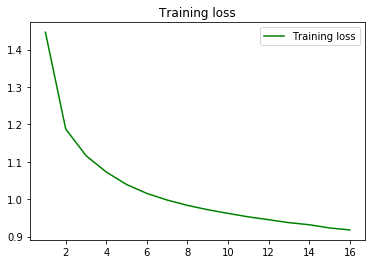

In [ ]:
history = model.fit(Xs, Ys, epochs=20, batch_size=128, validation_split=0.2,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

plot_history(history)

# RNN Model

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.models.Sequential([
    layers.Reshape((rows, cols), input_shape=(rows, cols)),
    layers.TimeDistributed(layers.Dense(cols)),
    layers.Bidirectional(layers.GRU(rows * 2, dropout=0.2, recurrent_dropout=0.2, activation="relu", return_sequences=True)),
    layers.Bidirectional(layers.GRU(rows * 2, dropout=0.2, recurrent_dropout=0.2, activation="relu", return_sequences=True)),
    layers.Reshape((rows * 160,)),                          
    layers.Dense(ys.shape[1])

])
model.summary()

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 40, 258)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 40, 258)           66822     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40, 160)           163200    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40, 160)           116160    
_________________________________________________________________
reshape_9 (Reshape)          (None, 6400)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 129)               825729    
Total params: 1,171,911
Trainable params: 1,171,911
Non-trainable params: 0
____________________________________________

In [16]:
print(Xs.shape, Ys.shape, rows, cols)

(12400, 40, 258) (12400, 129) 40 258


Train on 9920 samples, validate on 2480 samples
Epoch 1/20
9920/9920 [==============================] - 34s 3ms/sample - loss: 0.9418 - val_loss: 0.9542
Epoch 2/20
9920/9920 [==============================] - 24s 2ms/sample - loss: 0.9050 - val_loss: 0.9524
Epoch 3/20
9920/9920 [==============================] - 24s 2ms/sample - loss: 0.9005 - val_loss: 0.9522
Epoch 4/20
9920/9920 [==============================] - 24s 2ms/sample - loss: 0.8957 - val_loss: 0.9524
Epoch 5/20
9920/9920 [==============================] - 24s 2ms/sample - loss: 0.8914 - val_loss: 0.9527
Epoch 6/20
9920/9920 [==============================] - 24s 2ms/sample - loss: 0.8838 - val_loss: 0.9532
Epoch 7/20
9920/9920 [==============================] - 24s 2ms/sample - loss: 0.8726 - val_loss: 0.9547
Epoch 8/20
9920/9920 [==============================] - 24s 2ms/sample - loss: 0.8526 - val_loss: 0.9562
Epoch 9/20
9920/9920 [==============================] - 24s 2ms/sample - loss: 0.8237 - val_loss: 0.9602
Epoch 1

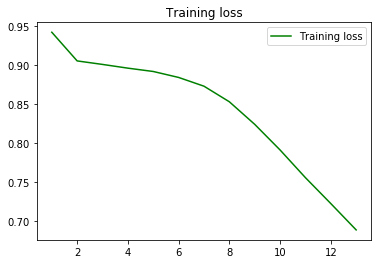

In [19]:
history = model.fit(Xs, Ys, epochs=20, batch_size=128, validation_split=0.2,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

plot_history(history)

# Multiheaded Model

This model has two inputs. The first (features) is the spectrogram (mag + phase) of the last N-1 timeslices, and the
second (quetion) is the magnitudes of the Nth timeslice (for which the phases must be predicted. 

In [30]:
import tensorflow as tf
from tensorflow.keras import layers

feature_input = layers.Input(shape=(rows - 1, cols), name='features')
question_input = layers.Input(shape=(cols // 2), name='question')

feature_layers = layers.TimeDistributed(layers.Dense(cols))(feature_input)
feature_layers = layers.Bidirectional(layers.GRU(rows * 2, dropout=0.2, recurrent_dropout=0.2, activation="relu", return_sequences=True))(feature_layers)
feature_layers = layers.Bidirectional(layers.GRU(rows * 2, dropout=0.2, recurrent_dropout=0.2, activation="relu", return_sequences=True))(feature_layers)
feature_layers = layers.Reshape(((rows - 1) * 160,))(feature_layers)

question_layers = layers.Dense(ys.shape[1])(question_input)

concatenated = layers.concatenate([feature_layers, question_layers])
answer = layers.Dense(ys.shape[1])(concatenated)

model = tf.keras.models.Model([feature_input, question_input], answer)

model.summary()

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 39, 258)]    0                                            
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 39, 258)      66822       features[0][0]                   
__________________________________________________________________________________________________
bidirectional_20 (Bidirectional (None, 39, 160)      163200      time_distributed_11[0][0]        
__________________________________________________________________________________________________
bidirectional_21 (Bidirectional (None, 39, 160)      116160      bidirectional_20[0][0]           
____________________________________________________________________________________________

Train on 9920 samples, validate on 2480 samples
Epoch 1/20
9920/9920 [==============================] - 33s 3ms/sample - loss: 0.9652 - val_loss: 0.9591
Epoch 2/20
9920/9920 [==============================] - 23s 2ms/sample - loss: 0.9077 - val_loss: 0.9572
Epoch 3/20
9920/9920 [==============================] - 23s 2ms/sample - loss: 0.9031 - val_loss: 0.9584
Epoch 4/20
9920/9920 [==============================] - 23s 2ms/sample - loss: 0.8973 - val_loss: 0.9580
Epoch 5/20
9920/9920 [==============================] - 23s 2ms/sample - loss: 0.8933 - val_loss: 0.9592
Epoch 6/20
9920/9920 [==============================] - 23s 2ms/sample - loss: 0.8892 - val_loss: 0.9600
Epoch 7/20
9920/9920 [==============================] - 23s 2ms/sample - loss: 0.8835 - val_loss: 0.9627
Epoch 8/20
9920/9920 [==============================] - 23s 2ms/sample - loss: 0.8721 - val_loss: 0.9630
Epoch 9/20
9920/9920 [==============================] - 23s 2ms/sample - loss: 0.8529 - val_loss: 0.9684
Epoch 1

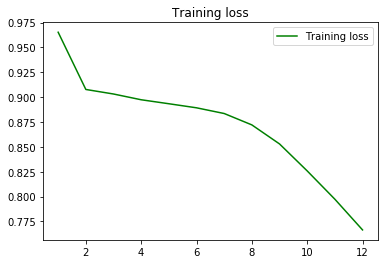

In [32]:
# Note the multipe inputs here. The first input is the spectrogram, excluding the very last
# time window. The second input is the magnitudes for the single (question) timeslice. The
# targets are still the phases for the question timeslice.

history = model.fit([Xs[:,:-1,:], Xs[:,-1,:cols // 2]], Ys, epochs=20, batch_size=128, validation_split=0.2,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

plot_history(history)

# Multiheaded Conv + RNN Model

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 39, 258)]    0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 39, 128)      396416      features[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_19 (MaxPooling1D) (None, 7, 128)       0           conv1d_19[0][0]                  
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 7, 64)        73792       max_pooling1d_19[0][0]           
___________________________________________________________________________________________

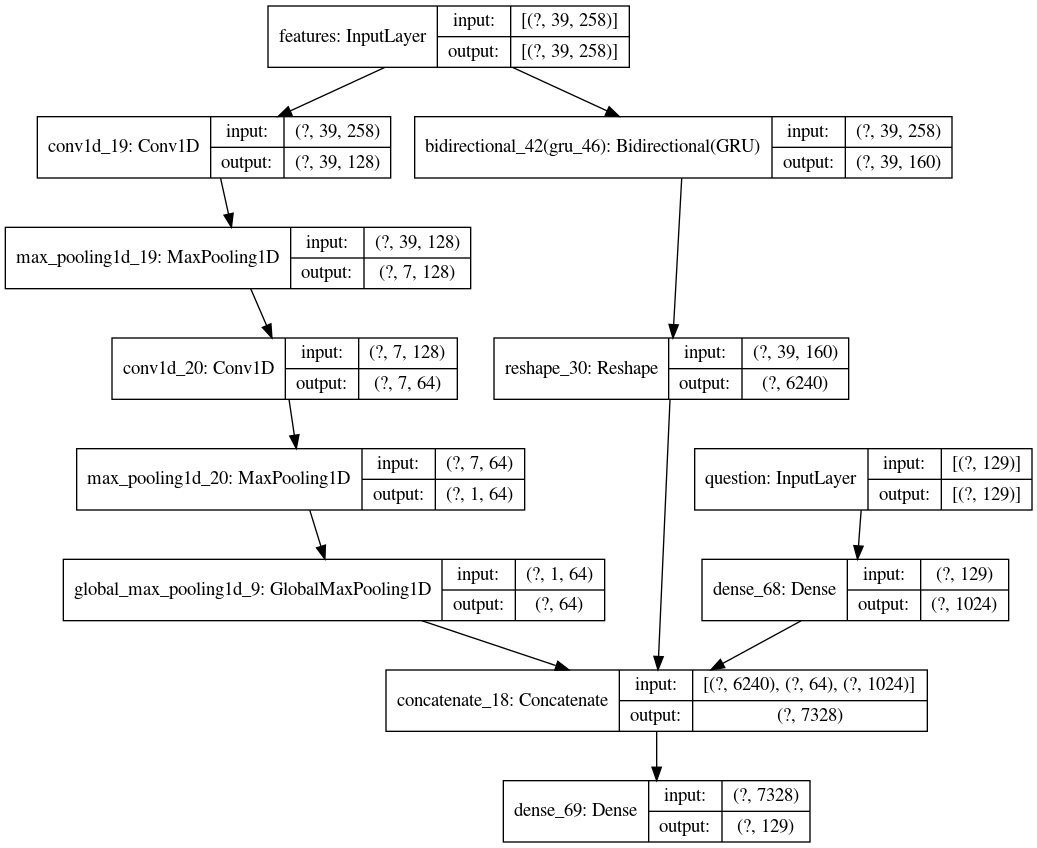

In [49]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

feature_input = layers.Input(shape=(rows - 1, cols), name='features')
question_input = layers.Input(shape=(cols // 2), name='question')

feature_layers = feature_input # layers.TimeDistributed(layers.Dense(cols))(feature_input)
feature_layers = layers.Bidirectional(layers.GRU(rows * 2, dropout=0.2, recurrent_dropout=0.2, activation="relu", return_sequences=True))(feature_layers)
feature_layers = layers.Reshape(((rows - 1) * 160,))(feature_layers)

conv_layers = layers.Conv1D(128, 12, padding="same", activation='relu')(feature_input)
conv_layers = layers.MaxPooling1D(pool_size=5)(conv_layers)
conv_layers = layers.Conv1D(64, 9, padding="same", activation='relu')(conv_layers)
conv_layers = layers.MaxPooling1D(pool_size=5)(conv_layers)
conv_layers = layers.GlobalMaxPooling1D()(conv_layers)

question_layers = layers.Dense(1024)(question_input)

concatenated = layers.concatenate([feature_layers, conv_layers, question_layers])
answer = layers.Dense(ys.shape[1])(concatenated)

model = tf.keras.models.Model([feature_input, question_input], answer)
model.summary()

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)
display.display(display.Image("model.png"))

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=optimizer)

Train on 24800 samples, validate on 6200 samples
Epoch 1/20
24800/24800 [==============================] - 37s 2ms/sample - loss: 1.0651 - val_loss: 0.9297
Epoch 2/20
24800/24800 [==============================] - 32s 1ms/sample - loss: 0.9469 - val_loss: 0.9221
Epoch 3/20
24800/24800 [==============================] - 31s 1ms/sample - loss: 0.9362 - val_loss: 0.9195
Epoch 4/20
24800/24800 [==============================] - 31s 1ms/sample - loss: 0.9273 - val_loss: 0.9173
Epoch 5/20
24800/24800 [==============================] - 31s 1ms/sample - loss: 0.9181 - val_loss: 0.9173
Epoch 6/20
24800/24800 [==============================] - 31s 1ms/sample - loss: 0.9056 - val_loss: 0.9190
Epoch 7/20
24800/24800 [==============================] - 32s 1ms/sample - loss: 0.8902 - val_loss: 0.9215
Epoch 8/20
24800/24800 [==============================] - 31s 1ms/sample - loss: 0.8741 - val_loss: 0.9241
Epoch 9/20
24800/24800 [==============================] - 31s 1ms/sample - loss: 0.8578 - val_l

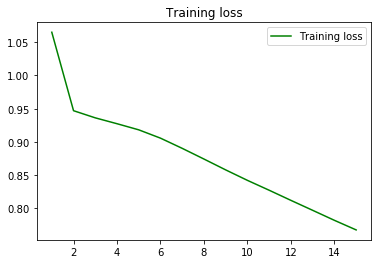

In [50]:
# Note the multipe inputs here. The first input is the spectrogram, excluding the very last
# time window. The second input is the magnitudes for the single (question) timeslice. The
# targets are still the phases for the question timeslice.

history = model.fit([Xs[:,:-1,:], Xs[:,-1,:cols // 2]], Ys, epochs=20, batch_size=128, validation_split=0.2,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

plot_history(history)

# Learn Phase from Magnitude

This (old) experiment is more raw. Give the network a magnitude spectrogram, and have it learn to predict
the phase spectrogram. Big ask.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.models.Sequential([
    layers.Dropout(0.2, input_shape=(rows, cols)),
    layers.Conv1D(128, 12, padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=5),

    layers.Conv1D(64, 9, padding="same", activation='relu'),
    layers.BatchNormalization(),

    # layers.Reshape((17, 100)),
    # layers.GRU(256, activation='relu', dropout=0.2,
    #    recurrent_dropout=0.2, return_sequences=False, input_shape=(rows, cols)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(4096, activation='relu'), 
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(ys.shape[1])
  ])

model.summary()

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [6]:
from skimage import util
from scipy.stats import describe

  # Transpose the data for the 1D convolutions (time on first axis)
dir_name = 'samples'
num_samples = 1000
config = DefaultConfig

# Swap if transposed
transpose = True
rows = config.cols
cols = config.rows

print("Shuffling samples...")
np.random.shuffle(files)
print("Generating spectrograms...")
Xs = np.empty((num_samples, rows, cols), dtype="complex64")
for i, file in enumerate(files[:num_samples]):
  f, t, Xs[i] = spectrogram_from_file(os.path.join("samples", file), config=config, render=False, transpose=transpose)
  if i % 100 == 0: print("Loaded:",i)

# Magnitude spectrogram on input
xs = np.absolute(Xs)[:,:rows,:cols]
ys = np.angle(Xs)[:,:rows,:cols]
print("xs", describe(xs.flatten()))
print("ys", describe(ys.flatten()))

xs_clip = np.quantile(xs, 0.75)
print("xs_clip", xs_clip)

xs = np.where(np.abs(xs) >= xs_clip, xs, 0)
ys = np.where(np.abs(xs) >= xs_clip, ys, 0)

print("xs (after_clipping)", describe(xs.flatten()))
print("ys (after_clipping)", describe(ys.flatten()))

print("Normalizing data...")
xs_mean, xs_std = normalize(xs)
ys_mean, ys_std = normalize(ys)

Shuffling samples...
Generating spectrograms...
Loaded: 0
Loaded: 100
Loaded: 200
Loaded: 300
Loaded: 400
Loaded: 500
Loaded: 600
Loaded: 700
Loaded: 800
Loaded: 900
xs DescribeResult(nobs=9159000, minmax=(1.933448e-06, 132.96097), mean=1.3681095, variance=22.432692, skewness=7.356823921203613, kurtosis=77.28114856656744)
ys DescribeResult(nobs=9159000, minmax=(-3.1415908, 3.1415927), mean=0.029005742, variance=3.3279254, skewness=-1.4955152437323704e-05, kurtosis=-1.1806567251302076)
xs_clip 0.4849531352519989
xs (after_clipping) DescribeResult(nobs=9159000, minmax=(0.0, 132.96097), mean=1.3046474, variance=22.587748, skewness=7.318460941314697, kurtosis=76.57356145626699)
ys (after_clipping) DescribeResult(nobs=9159000, minmax=(-3.1415808, 3.1415927), mean=0.00897063, variance=0.8333997, skewness=0.08749367296695709, kurtosis=4.288812696612031)
Normalizing data...


In [7]:
print(xs.shape, ys.shape)

(1000, 71, 129) (1000, 71, 129)


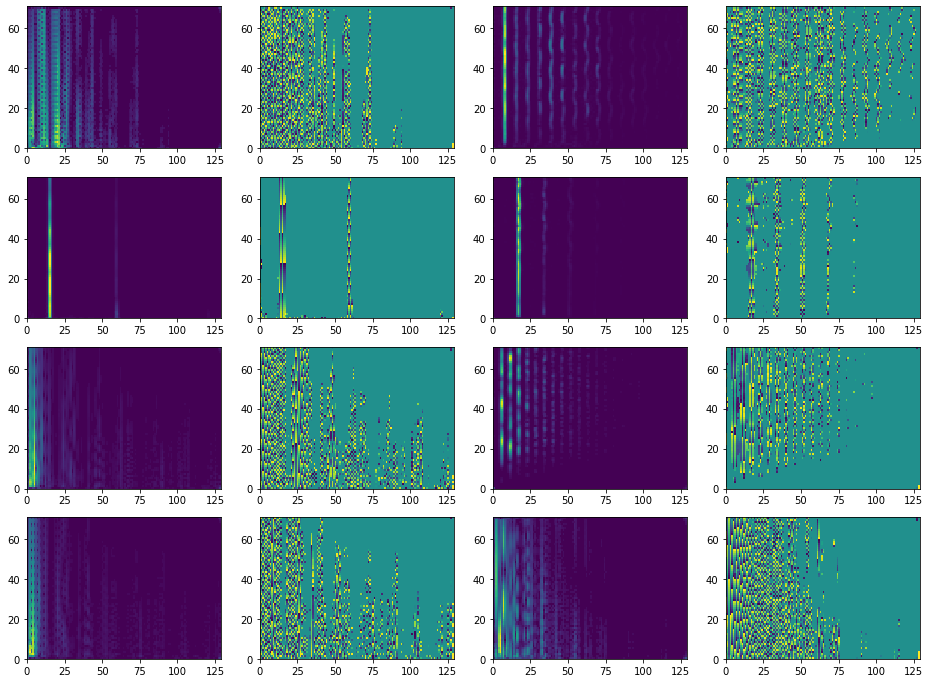

In [8]:
plt.figure(figsize=(16,12))
plt.axis('off')
for i in range(0,8):
  plt.subplot(4, 4, (2 * (i+1)) - 1)
  plt.pcolormesh(denormalize(xs[i], xs_mean, xs_std))
  plt.subplot(4, 4, 2 * (i+1))
  plt.pcolormesh(denormalize(ys[i], ys_mean, ys_std))
plt.show()

In [9]:
# Prune for convolutions (note swapped for transpose)
rows = 64
cols = 128
xs = xs[:,:rows,:cols]
ys = np.reshape(ys[:,:rows,:cols], (num_samples, rows * cols))

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.models.Sequential([
    layers.Reshape((rows, cols), input_shape=(rows, cols)),                          
    layers.GRU(rows * 2, dropout=0.2, recurrent_dropout=0.2, activation="relu", return_sequences=True),
    layers.GRU(rows * 2, dropout=0.2, recurrent_dropout=0.2, activation="relu", return_sequences=True),
    layers.Reshape((rows * cols,)),                          
    layers.Dense(rows * cols)
])
model.summary()

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 64, 128)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64, 128)           99072     
_________________________________________________________________
gru_7 (GRU)                  (None, 64, 128)           99072     
_________________________________________________________________
reshape_8 (Reshape)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 8192)              67117056  
Total params: 67,315,200
Trainable params: 67,315,200
Non-trainable params: 0
_________________________________________________________________


Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 13s 16ms/sample - loss: 1.0468 - val_loss: 1.0619
Epoch 2/20
800/800 [==============================] - 6s 8ms/sample - loss: 0.9961 - val_loss: 1.0579
Epoch 3/20
800/800 [==============================] - 6s 8ms/sample - loss: 0.9904 - val_loss: 1.0576
Epoch 4/20
800/800 [==============================] - 6s 8ms/sample - loss: 0.9853 - val_loss: 1.0587
Epoch 5/20
800/800 [==============================] - 6s 8ms/sample - loss: 0.9785 - val_loss: 1.0624
Epoch 6/20
800/800 [==============================] - 6s 8ms/sample - loss: 0.9678 - val_loss: 1.0659
Epoch 7/20
800/800 [==============================] - 6s 8ms/sample - loss: 0.9555 - val_loss: 1.0748
Epoch 8/20
800/800 [==============================] - 6s 8ms/sample - loss: 0.9430 - val_loss: 1.0791
Epoch 9/20
800/800 [==============================] - 6s 8ms/sample - loss: 0.9339 - val_loss: 1.0902
Epoch 10/20
800/800 [=============

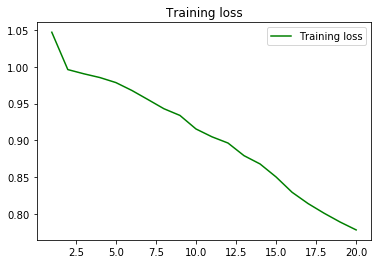

In [17]:
history = model.fit(xs, ys, epochs=20, batch_size=32, validation_split=0.2)
plot_history(history)

# Build Random Model

In [ ]:
def build_training_data(batch_size, audio_sample_size):
  audio = np.random.randn(batch_size, audio_sample_size)
  f, t, xs = spectrogram(audio)
  Xs = np.absolute(xs)
  (num_rows, num_cols) = (Xs.shape[1], Xs.shape[2])

  ys = np.reshape(xs, (batch_size, num_rows * num_cols))
  ys = np.hstack([ys.real, ys.imag])
  print(Xs.shape, ys.shape)
  return (Xs, ys, num_rows, num_cols)

In [ ]:
import tensorflow as tf

size = int(16000 * 0.25) # 25ms at 16khz
N = 15000

(xs, ys, rows, cols) = build_training_data(N, size)

(15000, 129, 17) (15000, 4386)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(rows, cols)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(rows * cols),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(rows * cols * 2)
])
model.summary()

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2193)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2193)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2193)              4811442   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2193)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4386)              9622884   
Total params: 14,434,326
Trainable params: 14,434,326
Non-trainable params: 0
_________________________________________________________________


(129, 17) (129, 17)
(1, 4386)


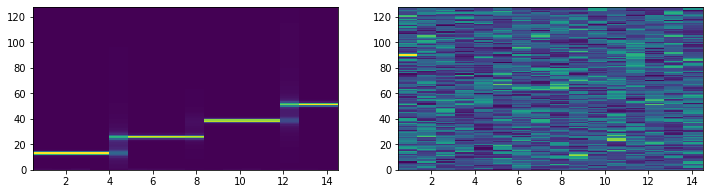

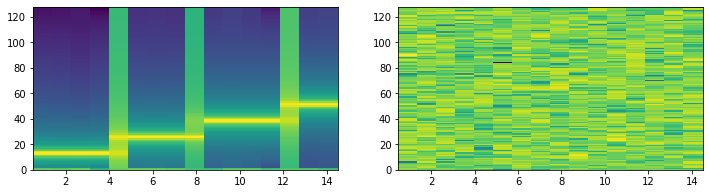

In [ ]:
def make_wave():
  # Create four evenly-spaced tones
  waves = []
  hz = 0
  for i in range(0, size, int(size / 4)):
    hz = hz + 50
    waves.append(np.sin(np.linspace(0, 2 * np.pi * hz, (size / 4))))
  return np.hstack(waves)

wave = make_wave()

# Calculate spectrogram using math
f, t, wave_sxx = spectrogram(wave)
wave_sxx_graph = np.absolute(wave_sxx)
print(wave_sxx.shape, wave_sxx_graph.shape)

# Calculate spectrogram using neural network
nn_sxx = model.predict(np.reshape(wave_sxx_graph, (1, rows, cols)))
print(nn_sxx.shape)
nn_sxx_graph = np.reshape(np.absolute(nn_sxx[0][:rows * cols] + 1j * nn_sxx[0][rows * cols:]), (rows, cols))

# Plot spectrograms side-by-side
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, f, wave_sxx_graph)
plt.subplot(1, 2, 2)
plt.pcolormesh(t, f, nn_sxx_graph)
plt.show()

# Plot log spectrograms side-by-side
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, f, np.log(wave_sxx_graph))
plt.subplot(1, 2, 2)
plt.pcolormesh(t, f, np.log(nn_sxx_graph))
plt.show()

In [ ]:
# Show error statistics
total_error = np.sum(wave_sxx_graph - nn_sxx_graph)
print(total_error)
mae = total_error / len(wave_sxx_graph)
print(mae)
print(np.allclose(wave_sxx_graph, nn_sxx_graph, atol=1e-07))

-6.665448066796888e-07
-5.167014005268905e-09
True


In [ ]:
weights_sxx = model.get_weights()[0]
print(weights_sxx.shape)
weights_sxx = np.reshape(weights_sxx, (size, rows * 2, cols))
print(weights_sxx.shape)
weights_sxx = np.moveaxis(weights_sxx, (0,1,2), (2,1,0))
print(weights_sxx.shape)

(2048, 8514)
(2048, 258, 33)
(33, 258, 2048)


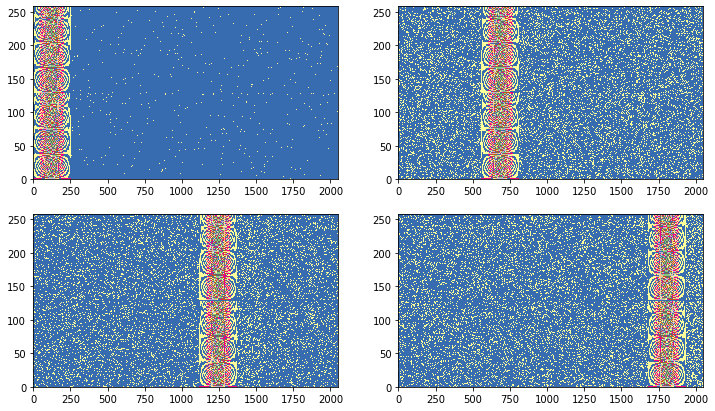

In [ ]:
#plt.figure(figsize=(10,10))
#plt.pcolormesh(np.expand_dims(np.dot(weights_sxx[20], wave), 0), cmap="Greys")
#plt.show()

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.pcolormesh(weights_sxx[0], cmap="Accent")
plt.subplot(2, 2, 2)
plt.pcolormesh(weights_sxx[10], cmap="Accent")
plt.subplot(2, 2, 3)
plt.pcolormesh(weights_sxx[20], cmap="Accent")
plt.subplot(2, 2, 4)
plt.pcolormesh(weights_sxx[30], cmap="Accent")
plt.show()

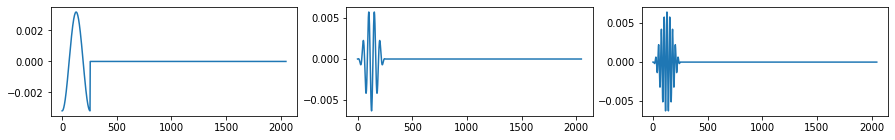

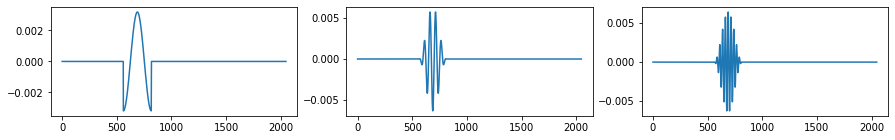

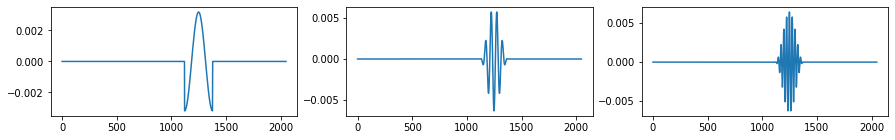

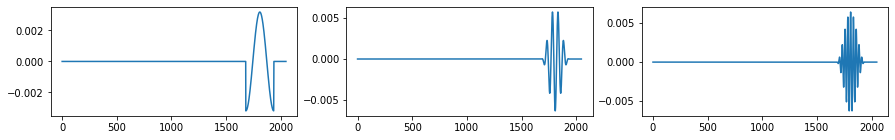

In [ ]:
def plot_weights(index, weights=weights_sxx):
  plt.figure(figsize=(15, 2))
  plt.subplot(1, 3, 1)
  plt.plot(weights[index][0])
  plt.subplot(1, 3, 2)
  plt.plot(weights[index][5])
  plt.subplot(1, 3, 3)
  plt.plot(weights[index][10])
  plt.show()

for index in [0, 10, 20, 30]:
  plot_weights(index)

In [ ]:
model.save("spectrogram-weights-256-15000-v4.h5")

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!gsutil -h "Cache-control:public,max-age=86400" cp -a public-read spectrogram-*v4.h5 gs://muthanna.com/deepears

Copying file://spectrogram-weights-256-15000-v4.h5 [Content-Type=application/octet-stream]...
/
Operation completed over 1 objects/266.1 MiB.                                    


In [ ]:
!wget --no-check-certificate https://muthanna.com/deepears/note-samples-v6.zip
!rm -rf samples
!unzip -q note-samples-v6.zip
!ls -l samples | head

--2020-03-02 16:08:33--  https://muthanna.com/deepears/note-samples-v6.zip
Resolving muthanna.com (muthanna.com)... 35.244.227.152
Connecting to muthanna.com (muthanna.com)|35.244.227.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412675997 (394M) [application/zip]
Saving to: ‘note-samples-v6.zip’

note-samples-v6.zip 100%[===================>] 393.56M   108MB/s    in 4.2s    

2020-03-02 16:08:37 (94.5 MB/s) - ‘note-samples-v6.zip’ saved [412675997/412675997]

total 621888
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-110.000-S0-V0.45-reject-attack.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-110.000-S0-V0.45-reject-decay.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-110.000-S0-V0.45-reject-sustain.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-127.000-S17-V0.68-reject-attack.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-127.000-S17-V0.68-reject-decay.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 no

Spectrogram for samples/note-Gs3-P0-248.652-S41-V0.93-noreject-sustain.wav
Spectrogram for samples/note-G6-P0-1634.982-S67-V0.41-noreject-attack.wav
Spectrogram for samples/note-Ds4-P6-311.127-S0-V0.24-noreject-sustain.wav
Spectrogram for samples/note-A7-P24-3543.000-S23-V0.33-noreject-sustain.wav
Spectrogram for samples/note-Cs3-P0-194.591-S56-V0.62-noreject-attack.wav
Spectrogram for samples/note-Gs7-P66-3353.438-S31-V0.8-noreject-attack.wav
Spectrogram for samples/note-F7-P48-2833.826-S40-V0.95-reject-attack.wav
Spectrogram for samples/note-C7-P19-2149.005-S56-V0.75-noreject-attack.wav
Spectrogram for samples/note-Fs7-P11-3007.955-S48-V0.26-noreject-attack.wav
Spectrogram for samples/note-D7-P61-2349.318-S0-V0.86-noreject-decay.wav
Spectrogram for samples/note-Gs7-P78-3371.438-S49-V0.83-noreject-sustain.wav
Spectrogram for samples/note-C3-P26-149.813-S19-V0.79-noreject-attack.wav
Spectrogram for samples/note-Cs3-P19-154.591-S16-V0.84-noreject-sustain.wav
Spectrogram for samples/note

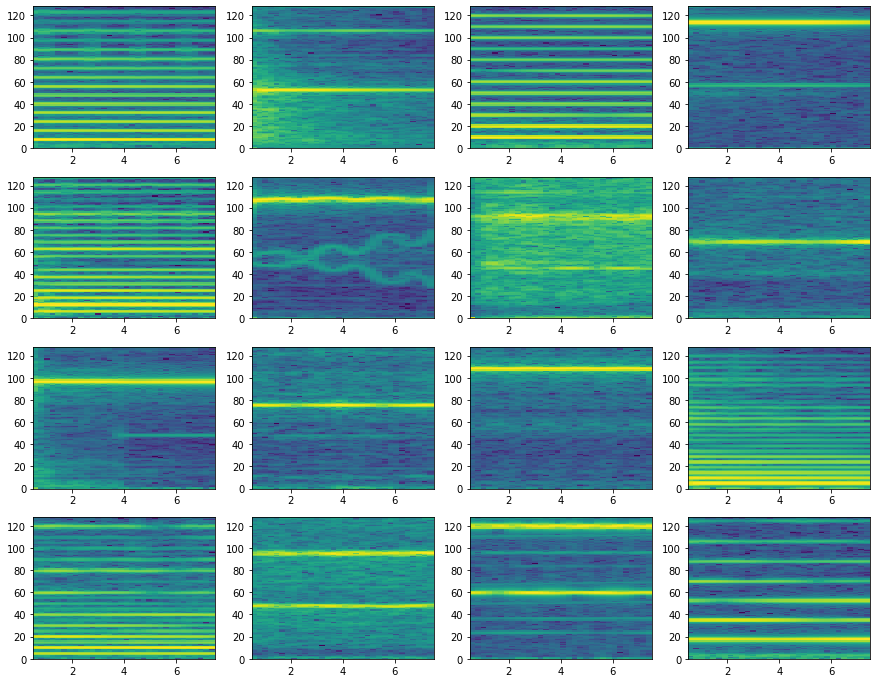

In [ ]:
import os
from scipy.io import wavfile

def plot_file_spectrogram(file, resample_rate=8000, window_size=size, rows=rows, cols=cols):
  print("Spectrogram for", file)
  fs, data = wavfile.read(file)

  number_of_samples = round(len(data) * float(resample_rate) / fs)
  data = signal.resample(data, number_of_samples)

  # Calculate spectrogram using neural network
  nn_sxx = model.predict(np.reshape(data[:window_size], (1, window_size)))
  nn_sxx_graph = np.reshape(np.absolute(nn_sxx[0][rows * cols:] + 1j * nn_sxx[0][:rows * cols]), (rows, cols))
  plt.pcolormesh(t, f, np.log(nn_sxx_graph))

files = os.listdir('samples')
plt.figure(figsize=(15, 12))
for i in range(0, 16):
  plt.subplot(4, 4, i+1)
  plot_file_spectrogram('samples/'+files[i])

plt.show()


# MNIST Experiment

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D


mnist = tf.keras.datasets.mnist

# Load the input data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:

# Build the model
model = tf.keras.models.Sequential([
  layers.Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
  layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
  layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="same"),
  layers.Conv2D(128, (3, 3), activation='relu', padding="same"),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
flatten_22 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_93 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_94 (Dense)             (None, 10)              

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 397s 8ms/sample - loss: 0.1077 - accuracy: 0.9665 - val_loss: 0.0522 - val_accuracy: 0.9850
Epoch 2/5
48000/48000 [==============================] - 396s 8ms/sample - loss: 0.0369 - accuracy: 0.9889 - val_loss: 0.0373 - val_accuracy: 0.9886
Epoch 3/5
48000/48000 [==============================] - 396s 8ms/sample - loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.0366 - val_accuracy: 0.9896
Epoch 4/5
48000/48000 [==============================] - 397s 8ms/sample - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0410 - val_accuracy: 0.9889
Epoch 5/5
48000/48000 [==============================] - 393s 8ms/sample - loss: 0.0122 - accuracy: 0.9958 - val_loss: 0.0394 - val_accuracy: 0.9903
